In [ ]:
import numpy as np
import pandas as pd
import sys
import os
from os.path import join
print(os.getcwd())

/content


## DOSI construction using Cox Proportional Hazards Model 

### Data preparation

#### Get CBC data

In [ ]:
path = '.../CBC/'
files = os.listdir(path)
print(files)

data = pd.read_sas(join(path, '{}'.format(files[0])))
for file in files[1:]:
    data_new = pd.read_sas(join(path, '{}'.format(file)))
    data = pd.concat([data, data_new], ignore_index=True)


['CBC_A.XPT', 'CBC_B.XPT', 'CBC_C.XPT', 'CBC_D.XPT', 'CBC_E.XPT', 'CBC_F.XPT', 'CBC_G.XPT', 'CBC_H.XPT']


In [ ]:
# Choose covariates as in the article:

studied = ["SEQN", "LBXWBCSI", "LBXHGB", "LBXRBCSI", "LBXMCVSI", "LBXMC", "LBXRDW", "LBXPLTSI", "LBXNEPCT", "LBXLYPCT", "LBXMOPCT", "LBXEOPCT"]
data_CBC = data[studied].sort_values(by=["SEQN"])
print(data_CBC.shape)


# Chech if some patients occur more than once in data:

data_CBC["SEQN"].drop_duplicates().shape

(74900, 12)


(74900,)

#### Get Age and Sex data

In [ ]:
path2 = '.../Age_sex/'
files2 = os.listdir(path2)
print(files2)

data2 = pd.read_sas(join(path2, '{}'.format(files2[0])))
for file2 in files2[1:]:
    data_new2 = pd.read_sas(join(path2, '{}'.format(file2))) 
    data2 = pd.concat([data2, data_new2], ignore_index=True)

['DEMO_A.XPT', 'DEMO_B.XPT', 'DEMO_C.XPT', 'DEMO_D.XPT', 'DEMO_E.XPT', 'DEMO_F.XPT', 'DEMO_G.XPT', 'DEMO_H.XPT']


C:\Users\sidma\anaconda3\lib\site-packages\pandas\io\sas\sas_xport.py:475: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[x] = v


In [ ]:
agesex = ["SEQN", "RIAGENDR", "RIDAGEYR"]
data_agesex = data2[agesex]
data_agesex.shape

(82091, 3)

#### Merge CBC, Age and Sex data using patients ids

In [ ]:
ids_CBC = data_CBC["SEQN"]
ids_agesex = data_agesex["SEQN"]
data_agesex = data_agesex[ids_agesex.isin(ids_CBC)].sort_values(by=["SEQN"])
data_agesex.shape

(74900, 3)

In [ ]:
data_CBC = data_CBC.reset_index(drop=True)
data_agesex = data_agesex.reset_index(drop=True)
data_live = pd.concat([data_CBC,data_agesex[["RIAGENDR", "RIDAGEYR"]]], axis = 1)
data_live.shape

(74900, 14)

#### Get rid of patients with Nans (as in the article)

In [ ]:
data_live.count()

SEQN        74900
LBXWBCSI    67278
LBXHGB      67281
LBXRBCSI    67281
LBXMCVSI    67281
LBXMC       67281
LBXRDW      67281
LBXPLTSI    67279
LBXNEPCT    67105
LBXLYPCT    67105
LBXMOPCT    67105
LBXEOPCT    67105
RIAGENDR    74900
RIDAGEYR    74900
dtype: int64

In [ ]:
data_live = data_live.dropna().reset_index(drop=True)
data_live.min()

SEQN        2.000000e+00
LBXWBCSI    1.400000e+00
LBXHGB      5.800000e+00
LBXRBCSI    1.670000e+00
LBXMCVSI    5.050000e+01
LBXMC       2.510000e+01
LBXRDW      6.300000e+00
LBXPLTSI    4.000000e+00
LBXNEPCT    8.000000e-01
LBXLYPCT    2.600000e+00
LBXMOPCT    6.000000e-01
LBXEOPCT    5.397605e-79
RIAGENDR    1.000000e+00
RIDAGEYR    1.000000e+00
dtype: float64

#### Converting white blood cell percentages into cell counts (as in the article)

In [ ]:
white_blood = ["LBXNEPCT", "LBXLYPCT", "LBXMOPCT", "LBXEOPCT"]
data_live[white_blood] = data_live[white_blood] * 0.01
data_live[white_blood] = data_live[white_blood].multiply(data_live["LBXWBCSI"], axis="index")
data_live = data_live.drop(["LBXWBCSI"],  axis = 1).sort_values(by=["SEQN"])
data_live.shape

(67101, 13)

#### Get mortality data

In [ ]:
path_death = '.../Mortality/CSV/'
files_death = os.listdir(path_death)
print(files_death)

data_death = pd.read_csv(join(path_death, '{}'.format(files_death[0])), sep = "\t")
for file_death in files_death[1:]:
    data_new_death = pd.read_csv(join(path_death, '{}'.format(file_death)), sep = "\t")
    data_death = pd.concat([data_death, data_new_death], ignore_index=True)

['NHANES_1999_2000.csv', 'NHANES_2001_2002.csv', 'NHANES_2003_2004.csv', 'NHANES_2005_2006.csv', 'NHANES_2007_2008.csv', 'NHANES_2009_2010.csv', 'NHANES_2011_2012.csv', 'NHANES_2013_2014.csv']


In [ ]:
data_death = data_death[["seqn", "mortstat", "permth_exm"]]
data_death.shape

(82091, 3)

#### Merge mortality data with previous patients data using patients ids

In [ ]:
ids_live = data_live["SEQN"]
ids_death = data_death["seqn"]
data_death = data_death[ids_death.isin(ids_live)].sort_values(by=["seqn"])
data_death.shape

(67101, 3)

In [ ]:
data_live = data_live.reset_index(drop=True)
data_death = data_death.reset_index(drop=True)
data_all = pd.concat([data_live,data_death[["mortstat", "permth_exm"]]], axis = 1)
data_all.shape

(67101, 15)

#### log-transformation of CBC parameters (as in the article)

In [ ]:
CBC_params = ["LBXHGB", "LBXRBCSI", "LBXMCVSI", "LBXMC", "LBXRDW", "LBXPLTSI", "LBXNEPCT", "LBXLYPCT", "LBXMOPCT", "LBXEOPCT"]
data_all[CBC_params] = np.log(data_all[CBC_params])

In [ ]:
data_all

,SEQN,LBXHGB,LBXRBCSI,LBXMCVSI,LBXMC,LBXRDW,LBXPLTSI,LBXNEPCT,LBXLYPCT,LBXMOPCT,LBXEOPCT,RIAGENDR,RIDAGEYR,mortstat,permth_exm
0,2.0,2.646175,1.553925,4.483003,3.514526,2.617396,5.365976,1.624681,0.472251,-0.616927,-1.095417,1.0,77.0,1.0,177.0
1,3.0,2.617396,1.508512,4.464758,3.549617,2.459589,5.598422,1.073294,1.042042,-0.498403,0.111094,2.0,10.0,NaN,NaN
2,4.0,2.230014,1.562346,4.119037,3.453157,2.727853,6.154858,0.751793,1.624839,-0.605869,0.003195,1.0,1.0,NaN,NaN
3,5.0,2.674149,1.635106,4.441474,3.505557,2.572612,5.342334,1.124865,0.802091,-1.005669,-1.606442,1.0,49.0,0.0,244.0
4,6.0,2.572612,1.439835,4.518522,3.517498,2.549445,6.115892,1.978073,0.621866,-1.119632,-1.650260,2.0,19.0,0.0,245.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67096,83725.0,2.541602,1.521699,4.426044,3.505557,2.587764,5.598422,1.007045,1.074080,-0.730226,0.104000,1.0,7.0,NaN,NaN
67097,83727.0,2.701361,1.623341,4.487512,3.493473,2.541602,5.420535,1.070624,0.486676,-1.119632,-1.640929,1.0,26.0,0.0,72.0
67098,83728.0,2.501436,1.439835,4.415220,3.555348,2.525729,6.089045,0.368386,1.491060,-0.786579,-1.554950,2.0,2.0,NaN,NaN
67099,83729.0,2.501436,1.425515,4.489759,3.490429,2.646175,5.361292,1.149052,0.899185,-0.456337,-2.107018,2.0,42.0,0.0,75.0


Altogether, the training subset comprised participants aged 40 y.o. and older. All CBC parameters were log-transformed and normalized to zero-mean and unit-variance based on data of NHANES participants aged 40 y.o. and older to further carry out PCA and train Cox proportional hazards model.
In Cox used log-transformed CBC measurements and sex variable (but not age) as covariates.

#### Train-test split as in the article:

In [ ]:
train = data_all[data_all.RIDAGEYR >= 40]
test = data_all[data_all.RIDAGEYR < 40]

In [ ]:
print(train.shape)
print(test.shape)

(25794, 15)
(41307, 15)


#### Scaling

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
scaler = StandardScaler()
scaler.fit(train[CBC_params])  

train[CBC_params] = scaler.transform(train[CBC_params])
test[CBC_params] = scaler.transform(test[CBC_params])

C:\Users\sidma\anaconda3\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
C:\Users\sidma\anaconda3\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


### 1A: PCA

In [ ]:
PCA_data_X = pd.concat([train[CBC_params], test[CBC_params]], ignore_index=True)
PCA_data_Y = pd.concat([train[["RIDAGEYR"]], test[["RIDAGEYR"]]], ignore_index=True)

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=3)
PCA_result = pca.fit_transform(PCA_data_X)

In [ ]:
PCA_result_age =  pd.concat([pd.DataFrame(PCA_result),PCA_data_Y], axis = 1)

In [ ]:
PCA_result_age.columns = PCA_result_age.columns.astype(str)
PCA_itog = PCA_result_age.groupby('RIDAGEYR')[["0", "1", "2"]].mean().reset_index(drop=False)
PCA_itog

,RIDAGEYR,0,1,2
0,1.0,2.927260,-0.514077,0.136926
1,2.0,2.170844,-0.138190,0.248139
2,3.0,1.740090,-0.008529,0.380440
3,4.0,1.399080,-0.048027,0.407578
4,5.0,1.227580,-0.029302,0.363167
...,...,...,...,...
80,81.0,-0.854237,0.207380,0.301759
81,82.0,-0.716904,0.132620,0.509531
82,83.0,-0.734880,-0.010363,0.337265
83,84.0,-0.503010,-0.069912,0.587524


In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D

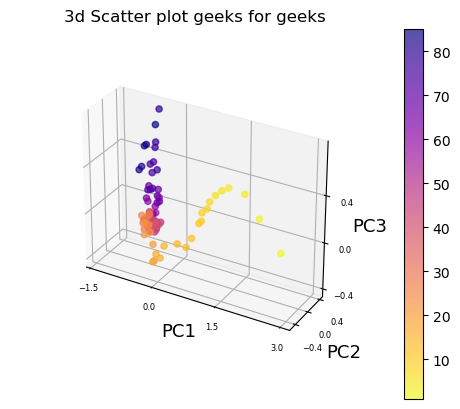

In [ ]:
fig = plt.figure()
ax = plt.axes(projection ='3d')
 
p = ax.scatter(PCA_itog["0"], PCA_itog["1"], PCA_itog["2"], c = PCA_itog["RIDAGEYR"], alpha=0.7, cmap = cm.plasma_r )
 
    
ax.set_title('3d Scatter plot geeks for geeks')
ax.set_xlabel('PC1', size = 13)
ax.set_ylabel("PC2", size = 13)
ax.set_zlabel("PC3", size = 13)
plt.xticks(size = 6)
plt.yticks(size = 6)
for t in ax.zaxis.get_major_ticks(): t.label.set_size(6)

ax.xaxis.set_ticks(np.arange(-1.5, 3.1, 1.5))
ax.yaxis.set_ticks(np.arange(-0.4, 0.41, 0.4))
ax.zaxis.set_ticks(np.arange(-0.4, 0.41, 0.4))

fig.colorbar(p, ax = ax)
ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([1, 0.3, 1, 1]))

plt.show()

### Cox

In [ ]:
train

,SEQN,LBXHGB,LBXRBCSI,LBXMCVSI,LBXMC,LBXRDW,LBXPLTSI,LBXNEPCT,LBXLYPCT,LBXMOPCT,LBXEOPCT,RIAGENDR,RIDAGEYR,mortstat,permth_exm
0,2.0,0.052801,0.271317,-0.254006,-0.328618,0.505580,-0.433887,0.665549,-0.529913,0.083342,0.157256,1.0,77.0,1.0,177.0
3,5.0,0.303057,1.002898,-0.875611,-0.644740,0.011453,-0.518236,-0.631315,0.381771,-1.068364,0.068833,1.0,49.0,0.0,244.0
5,7.0,-0.402732,0.020168,-0.441217,-0.644740,0.978523,0.034180,-1.598215,0.458768,-0.683812,-0.213664,2.0,59.0,0.0,236.0
8,10.0,0.841777,0.771586,0.375280,-0.433677,0.505580,-1.318636,-1.732354,-0.061419,-0.244954,0.025766,1.0,43.0,1.0,231.0
11,13.0,1.620185,1.679523,0.179401,-0.644740,1.055413,-0.207797,2.307305,-0.678628,-0.515816,-0.184487,1.0,70.0,1.0,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67091,83718.0,-0.605292,-1.284509,1.211004,-0.223871,0.744585,-0.009958,0.356941,0.487903,0.085537,-0.056002,2.0,60.0,0.0,84.0
67093,83721.0,0.241146,-0.218043,0.584629,0.500770,-0.244164,-1.654413,0.290061,-0.890244,0.489089,0.149423,1.0,52.0,0.0,76.0
67094,83723.0,0.178804,-1.127388,1.454394,1.610221,0.011453,-1.031417,-0.026343,1.103076,1.106975,-0.015521,1.0,61.0,0.0,82.0
67095,83724.0,-1.540267,-1.893329,0.616578,-0.015306,0.261282,-1.051183,0.175397,-1.427371,0.294691,-0.045335,1.0,80.0,0.0,80.0


In [ ]:
Cox = train.drop(["SEQN", "RIDAGEYR"],  axis = 1)
Cox.count()

LBXHGB        25794
LBXRBCSI      25794
LBXMCVSI      25794
LBXMC         25794
LBXRDW        25794
LBXPLTSI      25794
LBXNEPCT      25794
LBXLYPCT      25794
LBXMOPCT      25794
LBXEOPCT      25794
RIAGENDR      25794
mortstat      25761
permth_exm    25761
dtype: int64

In [ ]:
Cox = Cox.dropna()
Cox = Cox.rename(columns={'mortstat' : 'event_col', 'permth_exm' : 'duration_col'})
Cox.shape

(25761, 13)

#### Train-test split

In [ ]:
from sklearn.model_selection import train_test_split

Cox_train, Cox_test = train_test_split(Cox, test_size=0.5, 
                                       random_state=123, shuffle=True, 
                                        stratify=Cox["RIAGENDR"])

In [ ]:
Cox_train.shape

(12880, 13)

In [ ]:
Cox_train

,LBXHGB,LBXRBCSI,LBXMCVSI,LBXMC,LBXRDW,LBXPLTSI,LBXNEPCT,LBXLYPCT,LBXMOPCT,LBXEOPCT,RIAGENDR,event_col,duration_col
54138,-0.270195,-0.650692,0.947990,-0.644740,-0.864694,-0.569819,-1.054517,-0.623166,0.693491,0.033130,1.0,0.0,93.0
45897,1.349891,1.125035,0.680272,-0.644740,-0.594469,-0.972767,-0.370480,-1.398664,-1.867689,-0.236769,1.0,0.0,121.0
36164,-0.469744,-0.421478,-0.544328,1.110250,0.343317,-0.501206,-1.573508,-0.023561,-1.597203,-0.045669,2.0,0.0,144.0
45802,-0.336218,-1.060880,0.979174,0.398158,0.823117,-0.747358,-1.774419,0.845512,1.168895,-0.007829,1.0,1.0,88.0
43299,-0.673845,-1.038819,0.759511,-0.328618,-0.505844,0.408622,-0.410946,0.996013,-0.784374,-0.211907,2.0,0.0,115.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20895,-0.742926,-0.545780,-0.561582,0.398158,0.901093,0.830310,-0.153382,-0.724664,-0.327679,0.189372,1.0,1.0,63.0
6122,0.303057,0.515656,-0.203352,-0.433677,-1.048593,0.106552,-0.070964,-0.898110,-0.845339,0.012671,2.0,0.0,240.0
21298,0.606341,0.136953,0.632527,0.295246,-0.773882,-0.622159,-0.427093,-0.631736,0.309480,-0.023570,2.0,0.0,198.0
30923,1.726056,1.481816,0.536577,-0.433677,-0.683810,0.205467,0.131002,-0.385519,0.233219,0.072249,1.0,0.0,168.0


In [ ]:
#!pip install lifelines

In [ ]:
from lifelines import CoxPHFitter

In [ ]:
cph = CoxPHFitter()
cph.fit(Cox_train, duration_col = "duration_col", event_col = 'event_col' )

<lifelines.CoxPHFitter: fitted with 12880 total observations, 9333 right-censored observations>

In [ ]:
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 12880 total observations, 9333 right-censored observations>
             duration col = 'duration_col'
                event col = 'event_col'
      baseline estimation = breslow
   number of observations = 12880
number of events observed = 3547
   partial log-likelihood = -30677.18
         time fit was run = 2023-03-19 09:29:54 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
LBXHGB     -0.15       0.86       0.32            -0.78             0.49                 0.46                 1.62
LBXRBCSI   -0.12       0.88       0.32            -0.75             0.50                 0.47                 1.65
LBXMCVSI    0.37       1.45       0.19            -0.01             0.75                 0.99                 2.11
LBXMC      -0.13       0.88       0.08            -0.29             0.03                 0.75                 1.03
LBXRDW      0.32       1.38       0.02             0.29             0.35                 1.34                 1.42
LBXPLTSI   -0.16       0.85       0.02            -0.19            -0.13                 0.83                 0.88
LBXNEPCT    0.19       1.21       0.02             0.16             0.23                 1.17                 1.26
LBXLYPCT   -0.29       0.75       0.02            -0.32            -0.25                 0.72                 0.78
LBXMOPCT    0.27       1.31       0.02             0.23             0.31                 1.26                 1.36
LBXEOPCT    0.09       1.09       0.06            -0.04             0.21                 0.96                 1.23
RIAGENDR   -0.35       0.71       0.04            -0.42            -0.27                 0.65                 0.76

            cmp to      z      p   -log2(p)
covariate                                  
LBXHGB        0.00  -0.45   0.65       0.62
LBXRBCSI      0.00  -0.39   0.70       0.52
LBXMCVSI      0.00   1.93   0.05       4.21
LBXMC         0.00  -1.63   0.10       3.27
LBXRDW        0.00  20.95 <0.005     321.34
LBXPLTSI      0.00 -10.13 <0.005      77.72
LBXNEPCT      0.00  10.36 <0.005      81.12
LBXLYPCT      0.00 -16.05 <0.005     190.13
LBXMOPCT      0.00  13.27 <0.005     131.01
LBXEOPCT      0.00   1.37   0.17       2.55
RIAGENDR      0.00  -8.73 <0.005      58.47
---
Concordance = 0.72
Partial AIC = 61376.36
log-likelihood ratio test = 2052.07 on 11 df
-log2(p) of ll-ratio test = inf

In [ ]:
#cph.plot(hazard_ratios=False)

<AxesSubplot:xlabel='HR (95% CI)'>

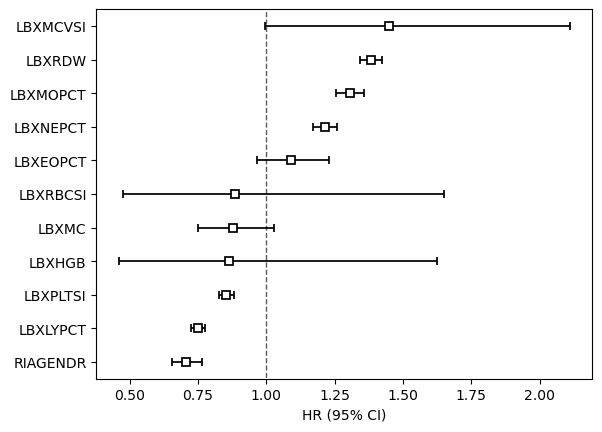

In [ ]:
cph.plot(hazard_ratios=True)

In [ ]:
Cox_train.describe()

,LBXHGB,LBXRBCSI,LBXMCVSI,LBXMC,LBXRDW,LBXPLTSI,LBXNEPCT,LBXLYPCT,LBXMOPCT,LBXEOPCT,RIAGENDR,event_col,duration_col
count,12880.000000,12880.000000,12880.000000,12880.000000,12880.000000,12880.000000,12880.000000,12880.000000,12880.000000,12880.000000,12880.000000,12880.000000,12880.000000
mean,-0.006079,-0.004546,-0.002950,0.002191,-0.003168,-0.004241,0.000526,-0.000097,0.007138,0.000144,1.509317,0.275388,127.825854
std,1.008042,1.004348,0.994428,1.008663,1.006602,0.998465,1.004849,0.998748,0.990335,1.000494,0.499933,0.446727,58.703695
min,-7.442962,-9.110873,-8.651593,-7.007641,-2.325014,-10.712949,-10.682425,-4.586342,-6.307882,-31.365633,1.000000,0.000000,0.000000
25%,-0.605292,-0.629612,-0.458353,-0.644740,-0.594469,-0.604627,-0.627275,-0.602563,-0.619779,-0.042193,1.000000,0.000000,82.000000
50%,0.052801,0.039738,0.097023,0.088516,-0.158299,0.034180,0.040354,0.023678,0.028201,0.035656,2.000000,0.000000,122.000000
75%,0.665784,0.681014,0.600612,0.603085,0.424747,0.625693,0.655307,0.639915,0.658430,0.110216,2.000000,1.000000,171.000000
max,3.044750,6.227398,4.950555,25.339866,11.703782,5.066864,7.919148,9.952183,8.784012,0.714875,2.000000,1.000000,249.000000


<AxesSubplot:>

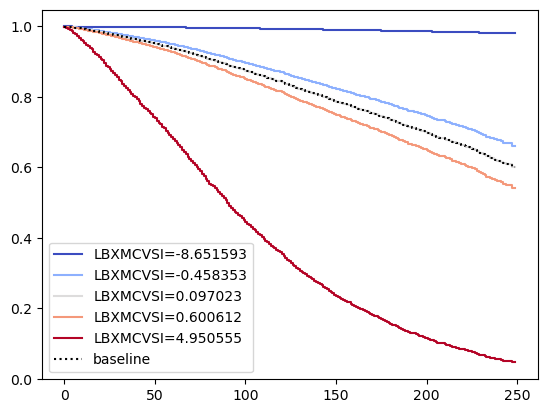

In [ ]:
cph.plot_partial_effects_on_outcome(covariates='LBXMCVSI', values=[-8.651593, -0.458353, 0.097023, 0.600612, 4.950555  ], cmap='coolwarm')

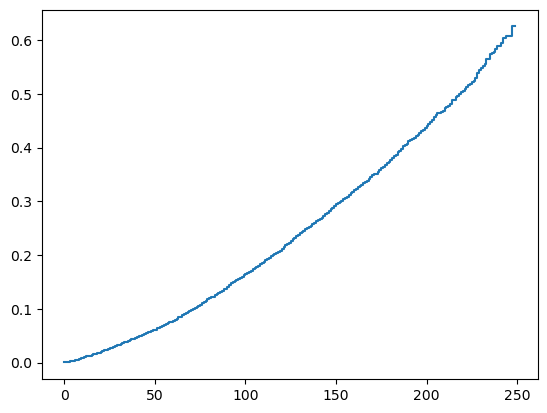

In [ ]:
plt.plot(cph.baseline_cumulative_hazard_, drawstyle="steps-post" )

#### Evaluation metrics

In [ ]:
#Loglikelihood
print(cph.score(Cox_train))
print(cph.score(Cox_test))

-2.381768817744922
-2.3713571287851862


In [ ]:
#AIC
print(cph.AIC_partial_)

61376.3647451092


In [ ]:
# Concordance index
print(cph.score(Cox_train, scoring_method="concordance_index"))
print(cph.score(Cox_test, scoring_method="concordance_index"))

0.7235763405968183
0.7199926560341724


Concordance index evaluates the accuracy of the ranking of predicted time. It is in fact a generalization of AUC, another common loss function, and is interpreted similarly:

0.5 is the expected result from random predictions,

1.0 is perfect concordance,

0.0 is perfect anti-concordance (multiply predictions with -1 to get 1.0)

#### Cox predictions for all patients

In [ ]:
Cox_all_data = pd.concat([train, test], ignore_index=True)
Cox_all = Cox_all_data.drop(["SEQN", "RIDAGEYR"],  axis = 1)
Cox_all = Cox_all.rename(columns={'mortstat' : 'event_col', 'permth_exm' : 'duration_col'})

print(Cox_all_data.shape)
print(Cox_all.shape)

(67101, 15)
(67101, 13)


In [ ]:
Cox_all

,LBXHGB,LBXRBCSI,LBXMCVSI,LBXMC,LBXRDW,LBXPLTSI,LBXNEPCT,LBXLYPCT,LBXMOPCT,LBXEOPCT,RIAGENDR,event_col,duration_col
0,0.052801,0.271317,-0.254006,-0.328618,0.505580,-0.433887,0.665549,-0.529913,0.083342,0.157256,1.0,1.0,177.0
1,0.303057,1.002898,-0.875611,-0.644740,0.011453,-0.518236,-0.631315,0.381771,-1.068364,0.068833,1.0,0.0,244.0
2,-0.402732,0.020168,-0.441217,-0.644740,0.978523,0.034180,-1.598215,0.458768,-0.683812,-0.213664,2.0,0.0,236.0
3,0.841777,0.771586,0.375280,-0.433677,0.505580,-1.318636,-1.732354,-0.061419,-0.244954,0.025766,1.0,1.0,231.0
4,1.620185,1.679523,0.179401,-0.644740,1.055413,-0.207797,2.307305,-0.678628,-0.515816,-0.184487,1.0,1.0,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
67096,-0.010872,0.117594,-0.085822,-0.223871,1.131771,-1.318636,0.428308,0.778047,-0.011498,-0.214549,1.0,0.0,77.0
67097,-0.882711,-0.019099,-1.106579,-0.644740,0.178633,0.395433,-0.937020,1.133553,-0.252324,0.364792,1.0,NaN,NaN
67098,0.546501,0.896876,-0.186506,-1.070695,-0.330703,-0.239231,-0.772052,-0.490041,-1.405997,0.062866,1.0,0.0,72.0
67099,-1.242038,-0.756839,-1.268593,1.110250,-0.505844,2.145874,-2.594136,2.286090,-0.419278,0.077743,2.0,NaN,NaN


In [ ]:
cph.predict_partial_hazard(Cox_all)

0        1.880782
1        0.517633
2        0.591318
3        1.156117
4        2.107190
           ...   
67096    1.770426
67097    0.566165
67098    0.676137
67099    0.102192
67100    0.292573
Length: 67101, dtype: float64

In [ ]:
Cox_all_data["Hazards_predicted"] = cph.predict_partial_hazard(Cox_all)
Cox_all_data["log-hazards"] = np.log(Cox_all_data["Hazards_predicted"])
Cox_all_data

,SEQN,LBXHGB,LBXRBCSI,LBXMCVSI,LBXMC,LBXRDW,LBXPLTSI,LBXNEPCT,LBXLYPCT,LBXMOPCT,LBXEOPCT,RIAGENDR,RIDAGEYR,mortstat,permth_exm,Hazards_predicted,log-hazards
0,2.0,0.052801,0.271317,-0.254006,-0.328618,0.505580,-0.433887,0.665549,-0.529913,0.083342,0.157256,1.0,77.0,1.0,177.0,1.880782,0.631688
1,5.0,0.303057,1.002898,-0.875611,-0.644740,0.011453,-0.518236,-0.631315,0.381771,-1.068364,0.068833,1.0,49.0,0.0,244.0,0.517633,-0.658489
2,7.0,-0.402732,0.020168,-0.441217,-0.644740,0.978523,0.034180,-1.598215,0.458768,-0.683812,-0.213664,2.0,59.0,0.0,236.0,0.591318,-0.525401
3,10.0,0.841777,0.771586,0.375280,-0.433677,0.505580,-1.318636,-1.732354,-0.061419,-0.244954,0.025766,1.0,43.0,1.0,231.0,1.156117,0.145067
4,13.0,1.620185,1.679523,0.179401,-0.644740,1.055413,-0.207797,2.307305,-0.678628,-0.515816,-0.184487,1.0,70.0,1.0,16.0,2.107190,0.745355
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67096,83720.0,-0.010872,0.117594,-0.085822,-0.223871,1.131771,-1.318636,0.428308,0.778047,-0.011498,-0.214549,1.0,36.0,0.0,77.0,1.770426,0.571220
67097,83725.0,-0.882711,-0.019099,-1.106579,-0.644740,0.178633,0.395433,-0.937020,1.133553,-0.252324,0.364792,1.0,7.0,NaN,NaN,0.566165,-0.568870
67098,83727.0,0.546501,0.896876,-0.186506,-1.070695,-0.330703,-0.239231,-0.772052,-0.490041,-1.405997,0.062866,1.0,26.0,0.0,72.0,0.676137,-0.391360
67099,83728.0,-1.242038,-0.756839,-1.268593,1.110250,-0.505844,2.145874,-2.594136,2.286090,-0.419278,0.077743,2.0,2.0,NaN,NaN,0.102192,-2.280899


#### Get weight data

In [ ]:
path3 = 'C:\\Users\\sidma\\Downloads\\Weight\\'
files3 = os.listdir(path3)
print(files3)

data3 = pd.read_sas(join(path3, '{}'.format(files3[0])))
for file3 in files3[1:]:
    data_new3 = pd.read_sas(join(path3, '{}'.format(file3))) 
    data3 = pd.concat([data3, data_new3], ignore_index=True)

    
weight = ["SEQN","BMXWT"]
data_weight = data3[weight]
data_weight.shape

['BMX_A.XPT', 'BMX_B.XPT', 'BMX_C.XPT', 'BMX_D.XPT', 'BMX_E.XPT', 'BMX_F.XPT', 'BMX_G.XPT', 'BMX_H.XPT']


(78518, 2)

In [ ]:
ids_Cox = Cox_all_data["SEQN"]
ids_weight = data_weight["SEQN"]
data_weight = data_weight[ids_weight.isin(ids_Cox)]

print(data_weight.shape)


Cox_all_data = Cox_all_data.sort_values(by=["SEQN"]).reset_index(drop=True)
data_weight = data_weight.sort_values(by=["SEQN"]).reset_index(drop=True)
Cox_all_data = pd.concat([Cox_all_data,data_weight[["BMXWT"]]], axis = 1)
Cox_all_data.shape

(67101, 2)


(67101, 18)

In [ ]:
scaler_weight = StandardScaler()
scaler_weight.fit(Cox_all_data[["BMXWT"]])  

Cox_all_data["weight_normalised"] = scaler_weight.transform(Cox_all_data[["BMXWT"]])

#### DOSI = log-hazards

In [ ]:
bins = list(np.arange(0, 88, 5))
labels = list(np.arange(1, 85, 5))
Cox_all_data['age_binned'] = pd.cut(Cox_all_data["RIDAGEYR"], bins=bins, labels=labels)

In [ ]:
Cox_final_binned = Cox_all_data[['age_binned', "log-hazards", "BMXWT", "weight_normalised"]].groupby('age_binned').describe().reset_index(drop=False)

#Cox_final_binned.columns

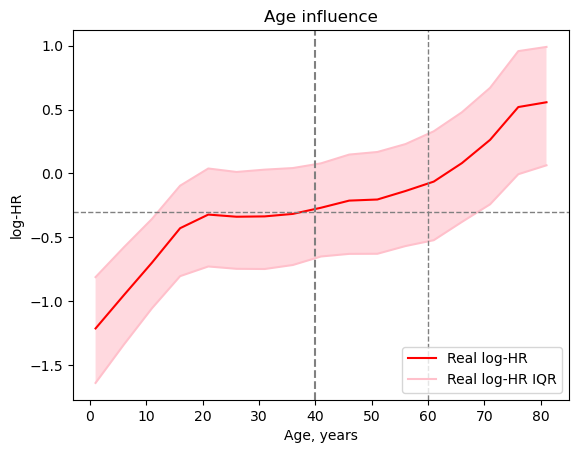

In [ ]:
plt.plot(Cox_final_binned [( 'age_binned', '')], Cox_final_binned [('log-hazards', 'mean')], c = "red", label = "Real log-HR")
plt.plot(Cox_final_binned [( 'age_binned', '')], Cox_final_binned [('log-hazards', '25%')], c = "pink", label = "Real log-HR IQR")
plt.plot(Cox_final_binned [( 'age_binned', '')], Cox_final_binned [('log-hazards', '75%')], c = "pink")
plt.fill_between(Cox_final_binned [( 'age_binned', '')], Cox_final_binned [('log-hazards', '25%')], Cox_final_binned [('log-hazards', '75%')], facecolor= "pink", alpha = 0.6)


plt.axvline(x=40,  color='grey', ls='--', lw=1.5)
plt.axvline(x=60,  color='grey', ls='--', lw=1)
plt.axhline(y=-0.3,  color='grey', ls='--', lw=1)

plt.legend(loc='lower right')
plt.ylabel('log-HR')
plt.xlabel('Age, years')
plt.title('Age influence');

#### Body mass and treoretical projectory

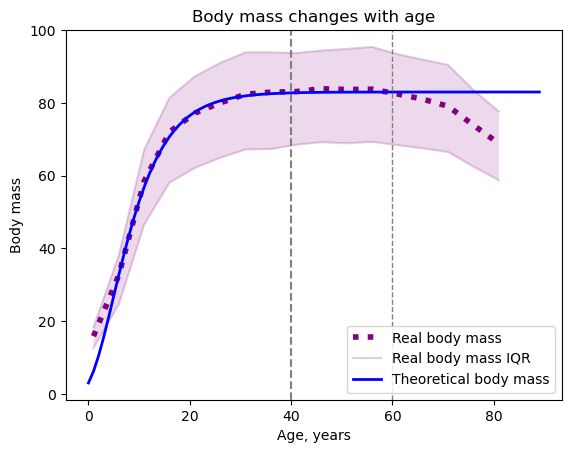

In [ ]:

plt.plot(Cox_final_binned [( 'age_binned', '')], Cox_final_binned [("BMXWT", 'mean')],ls=':', lw=4, c = "purple", label = 'Real body mass')
plt.plot(Cox_final_binned [( 'age_binned', '')], Cox_final_binned [("BMXWT", '25%')], c = "purple", alpha = 0.2, label = 'Real body mass IQR')
plt.plot(Cox_final_binned [( 'age_binned', '')], Cox_final_binned [("BMXWT", '75%')], c = "purple", alpha = 0.2)
plt.fill_between(Cox_final_binned [( 'age_binned', '')], Cox_final_binned [("BMXWT", '25%')], Cox_final_binned [("BMXWT", '75%')], facecolor= "purple", alpha = 0.15)

x = lambda t, t0, X, x0:  X * (1 - (1-(x0/X)**(1/4))*np.exp(-t/t0))**4  

t = np.arange(0, 90)
t0 = 6
X = 83
x0 = 3

plt.plot(t, x(t, t0, X, x0 ), label='Theoretical body mass',  c = "blue", lw = 2);

#plt.axvline(x=20,  color='lightgrey', ls='--', lw=2)
plt.axvline(x=40,  color='grey', ls='--', lw=1.5)
plt.axvline(x=60,  color='grey', ls='--', lw=1)
#plt.axhline(y=83,  color='grey', ls='--', lw=1)

plt.legend(loc='lower right')
plt.ylabel('Body mass')
plt.xlabel('Age, years')
plt.title('Body mass changes with age');

#### 1B: Hazard and bogy mass on one plot

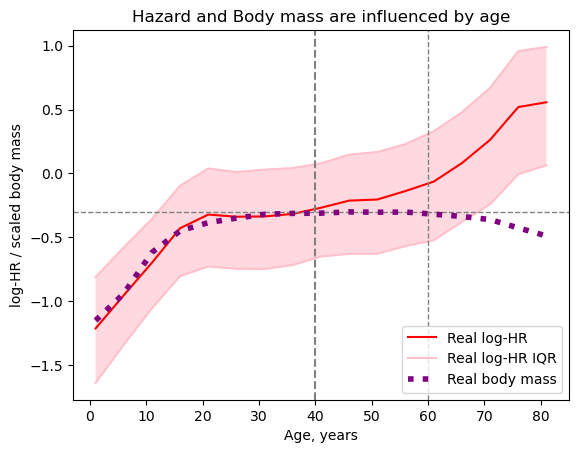

In [ ]:
plt.plot(Cox_final_binned [( 'age_binned', '')], Cox_final_binned [('log-hazards', 'mean')], c = "red", label = "Real log-HR")
plt.plot(Cox_final_binned [( 'age_binned', '')], Cox_final_binned [('log-hazards', '25%')], c = "pink", label = "Real log-HR IQR")
plt.plot(Cox_final_binned [( 'age_binned', '')], Cox_final_binned [('log-hazards', '75%')], c = "pink")
plt.fill_between(Cox_final_binned [( 'age_binned', '')], Cox_final_binned [('log-hazards', '25%')], Cox_final_binned [('log-hazards', '75%')], facecolor= "pink", alpha = 0.6)


plt.axvline(x=40,  color='grey', ls='--', lw=1.5)
plt.axvline(x=60,  color='grey', ls='--', lw=1)
plt.axhline(y=-0.3,  color='grey', ls='--', lw=1)

plt.plot(Cox_final_binned [( 'age_binned', '')], Cox_final_binned [("BMXWT", 'mean')] /80 - 1.35, c = "purple", ls=':', lw=4, label = 'Real body mass' )

plt.legend(loc='lower right')
plt.ylabel('log-HR / scaled body mass')
plt.xlabel('Age, years')
plt.title('Hazard and Body mass are influenced by age');

In [ ]:
Cox_all_data

,SEQN,LBXHGB,LBXRBCSI,LBXMCVSI,LBXMC,LBXRDW,LBXPLTSI,LBXNEPCT,LBXLYPCT,LBXMOPCT,LBXEOPCT,RIAGENDR,RIDAGEYR,mortstat,permth_exm,Hazards_predicted,log-hazards,BMXWT,weight_normalised,age_binned
0,2.0,0.052801,0.271317,-0.254006,-0.328618,0.505580,-0.433887,0.665549,-0.529913,0.083342,0.157256,1.0,77.0,1.0,177.0,1.880782,0.631688,75.4,0.322719,76
1,3.0,-0.204656,-0.137938,-0.527093,0.908259,-1.235608,0.395433,-0.765124,1.044998,0.434488,0.366020,2.0,10.0,NaN,NaN,0.300238,-1.203180,32.9,-1.143486,6
2,4.0,-3.670187,0.347206,-5.701905,-2.491711,1.724324,2.380682,-1.599316,2.655858,0.116103,0.347350,1.0,1.0,NaN,NaN,0.141818,-1.953211,13.3,-1.819665,1
3,5.0,0.303057,1.002898,-0.875611,-0.644740,0.011453,-0.518236,-0.631315,0.381771,-1.068364,0.068833,1.0,49.0,0.0,244.0,0.517633,-0.658489,92.5,0.912651,46
4,6.0,-0.605292,-0.756839,0.277661,-0.223871,-0.244164,2.241660,1.582488,-0.116375,-1.405997,0.061251,2.0,19.0,0.0,245.0,0.724123,-0.322794,59.2,-0.236164,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67096,83725.0,-0.882711,-0.019099,-1.106579,-0.644740,0.178633,0.395433,-0.937020,1.133553,-0.252324,0.364792,1.0,7.0,NaN,NaN,0.566165,-0.568870,22.8,-1.491925,6
67097,83727.0,0.546501,0.896876,-0.186506,-1.070695,-0.330703,-0.239231,-0.772052,-0.490041,-1.405997,0.062866,1.0,26.0,0.0,72.0,0.676137,-0.391360,71.8,0.198523,26
67098,83728.0,-1.242038,-0.756839,-1.268593,1.110250,-0.505844,2.145874,-2.594136,2.286090,-0.419278,0.077743,2.0,2.0,NaN,NaN,0.102192,-2.280899,11.3,-1.888663,1
67099,83729.0,-1.242038,-0.885888,-0.152869,-1.177993,0.823117,-0.450598,-0.568557,0.650140,0.559114,-0.017782,2.0,42.0,0.0,75.0,1.496126,0.402879,89.6,0.812604,41


In [ ]:
Cox_all_data.to_csv("Cox_all_data", sep='\t')

## Frialty investigation

### Data preparation

#### Get frial data

In [ ]:
Cox_all_data = pd.read_csv('.../Cox_all_data.csv', sep='\t', index_col= 0)

In [ ]:
Cox_all_data

,SEQN,LBXHGB,LBXRBCSI,LBXMCVSI,LBXMC,LBXRDW,LBXPLTSI,LBXNEPCT,LBXLYPCT,LBXMOPCT,LBXEOPCT,RIAGENDR,RIDAGEYR,mortstat,permth_exm,Hazards_predicted,log-hazards,BMXWT,weight_normalised,age_binned
0,2.0,0.052801,0.271317,-0.254006,-0.328618,0.505580,-0.433887,0.665549,-0.529913,0.083342,0.157256,1.0,77.0,1.0,177.0,1.880782,0.631688,75.4,0.322719,76
1,3.0,-0.204656,-0.137938,-0.527093,0.908259,-1.235608,0.395433,-0.765124,1.044998,0.434488,0.366020,2.0,10.0,NaN,NaN,0.300238,-1.203180,32.9,-1.143486,6
2,4.0,-3.670187,0.347206,-5.701905,-2.491711,1.724324,2.380682,-1.599316,2.655858,0.116103,0.347350,1.0,1.0,NaN,NaN,0.141818,-1.953211,13.3,-1.819665,1
3,5.0,0.303057,1.002898,-0.875611,-0.644740,0.011453,-0.518236,-0.631315,0.381771,-1.068364,0.068833,1.0,49.0,0.0,244.0,0.517633,-0.658489,92.5,0.912651,46
4,6.0,-0.605292,-0.756839,0.277661,-0.223871,-0.244164,2.241660,1.582488,-0.116375,-1.405997,0.061251,2.0,19.0,0.0,245.0,0.724123,-0.322794,59.2,-0.236164,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67096,83725.0,-0.882711,-0.019099,-1.106579,-0.644740,0.178633,0.395433,-0.937020,1.133553,-0.252324,0.364792,1.0,7.0,NaN,NaN,0.566165,-0.568870,22.8,-1.491925,6
67097,83727.0,0.546501,0.896876,-0.186506,-1.070695,-0.330703,-0.239231,-0.772052,-0.490041,-1.405997,0.062866,1.0,26.0,0.0,72.0,0.676137,-0.391360,71.8,0.198523,26
67098,83728.0,-1.242038,-0.756839,-1.268593,1.110250,-0.505844,2.145874,-2.594136,2.286090,-0.419278,0.077743,2.0,2.0,NaN,NaN,0.102192,-2.280899,11.3,-1.888663,1
67099,83729.0,-1.242038,-0.885888,-0.152869,-1.177993,0.823117,-0.450598,-0.568557,0.650140,0.559114,-0.017782,2.0,42.0,0.0,75.0,1.496126,0.402879,89.6,0.812604,41


In [ ]:
path = '.../MCQ/XPT/'
files = os.listdir(path)
print(files)

data_frial = pd.read_sas(join(path, '{}'.format(files[0])))
for file in files[1:]:
    data_new = pd.read_sas(join(path, '{}'.format(file)))
    data_frial = pd.concat([data_frial, data_new], ignore_index=True)

['MCQ_05_06.XPT', 'MCQ_13_14.XPT', 'MCQ_03_04.XPT', 'MCQ_09_10.XPT', 'MCQ_99_00.XPT', 'MCQ_01_02.XPT', 'MCQ_07_08.XPT', 'MCQ_11_12.XPT']


<ipython-input-103-f7523ed17793>:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_new = pd.read_sas(join(path, '{}'.format(file)))
<ipython-input-103-f7523ed17793>:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_new = pd.read_sas(join(path, '{}'.format(file)))
<ipython-input-103-f7523ed17793>:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a 

In [ ]:
data_frial

,SEQN,MCQ010,MCQ025,MCQ035,MCQ040,MCQ050,MCQ053,MCQ080,MCQ092,MCD093,...,MCQ260DD,MCQ260DE,MCQ260DF,MCQ260DG,MCQ260DH,MCQ260DI,MCD147,MCD160M,MCD170M,MCD180M
0,31128.0,2.0,NaN,NaN,NaN,NaN,2.0,NaN,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,31129.0,2.0,NaN,NaN,NaN,NaN,2.0,NaN,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,31130.0,2.0,NaN,NaN,NaN,NaN,2.0,2.0,9.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,31131.0,2.0,NaN,NaN,NaN,NaN,2.0,2.0,1.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,31132.0,2.0,NaN,NaN,NaN,NaN,2.0,2.0,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78334,71912.0,2.0,NaN,NaN,NaN,NaN,2.0,2.0,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
78335,71913.0,2.0,NaN,NaN,NaN,NaN,2.0,2.0,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
78336,71914.0,1.0,3.0,1.0,1.0,2.0,2.0,NaN,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
78337,71915.0,2.0,NaN,NaN,NaN,NaN,2.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Data coded in following way:
1 - Yes; 2 - No; 7 - Refused; 9 - Don't know

MCQ100 - hypertension;
MCQ160A - arthritis;
MCQ220 - cancer;
MCQ160C - coronary heart disease;
MCQ160D - angina/angina pectoris;
MCQ160G - emphysema;
MCQ160E - heart attack;
MCQ160F - stroke;
MCQ160B - congestive heart failure;
MCQ160K - chronic bronchitis;

In [ ]:
col_fr = ["SEQN", "MCQ100","MCQ160A","MCQ220","MCQ160C","MCQ160D","MCQ160G","MCQ160E","MCQ160F","MCQ160B","MCQ160K"]
data_frial = data_frial[col_fr]
data_frial.shape

(78339, 11)

In [ ]:
data_frial_sum = data_frial[data_frial.iloc[:,1:] == 1].sum(axis = 1)
data_frial_sum.value_counts()

0.0    61843
1.0    10140
2.0     3799
3.0     1388
4.0      699
5.0      291
6.0      116
7.0       53
8.0        9
9.0        1
dtype: int64

####CMI calculation

In [ ]:
data_frial['n_diagnoses'] = data_frial_sum
data_frial['CMI'] = data_frial['n_diagnoses']/10

<ipython-input-107-5c99dfe8f6cc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_frial['n_diagnoses'] = data_frial_sum
<ipython-input-107-5c99dfe8f6cc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_frial['CMI'] = data_frial['n_diagnoses']/10


In [ ]:
data_frial

,SEQN,MCQ100,MCQ160A,MCQ220,MCQ160C,MCQ160D,MCQ160G,MCQ160E,MCQ160F,MCQ160B,MCQ160K,n_diagnoses,CMI
0,31128.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
1,31129.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
2,31130.0,NaN,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0,0.0
3,31131.0,NaN,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,1.0,0.1
4,31132.0,NaN,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
78334,71912.0,NaN,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0,0.0
78335,71913.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
78336,71914.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
78337,71915.0,NaN,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0,0.0


####Merge with previous data

In [ ]:
ids = Cox_all_data["SEQN"]
ids_frial = data_frial["SEQN"]
data_frial = data_frial[ids_frial.isin(ids)].sort_values(by=["SEQN"])
data_frial.shape

(67101, 13)

In [ ]:
data_frial = data_frial.reset_index(drop=True)
Cox_all_data = Cox_all_data.reset_index(drop=True)
Cox_all_data_fr = pd.concat([Cox_all_data,data_frial.iloc[:,1:]], axis = 1)
Cox_all_data_fr.shape

(67101, 32)

In [ ]:
Cox_all_data_fr

,SEQN,LBXHGB,LBXRBCSI,LBXMCVSI,LBXMC,LBXRDW,LBXPLTSI,LBXNEPCT,LBXLYPCT,LBXMOPCT,...,MCQ220,MCQ160C,MCQ160D,MCQ160G,MCQ160E,MCQ160F,MCQ160B,MCQ160K,n_diagnoses,CMI
0,2.0,0.052801,0.271317,-0.254006,-0.328618,0.505580,-0.433887,0.665549,-0.529913,0.083342,...,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0.2
1,3.0,-0.204656,-0.137938,-0.527093,0.908259,-1.235608,0.395433,-0.765124,1.044998,0.434488,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
2,4.0,-3.670187,0.347206,-5.701905,-2.491711,1.724324,2.380682,-1.599316,2.655858,0.116103,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
3,5.0,0.303057,1.002898,-0.875611,-0.644740,0.011453,-0.518236,-0.631315,0.381771,-1.068364,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0,0.0
4,6.0,-0.605292,-0.756839,0.277661,-0.223871,-0.244164,2.241660,1.582488,-0.116375,-1.405997,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67096,83725.0,-0.882711,-0.019099,-1.106579,-0.644740,0.178633,0.395433,-0.937020,1.133553,-0.252324,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
67097,83727.0,0.546501,0.896876,-0.186506,-1.070695,-0.330703,-0.239231,-0.772052,-0.490041,-1.405997,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0,0.0
67098,83728.0,-1.242038,-0.756839,-1.268593,1.110250,-0.505844,2.145874,-2.594136,2.286090,-0.419278,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
67099,83729.0,-1.242038,-0.885888,-0.152869,-1.177993,0.823117,-0.450598,-0.568557,0.650140,0.559114,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0,0.0


In [ ]:
Cox_all_data_fr.to_csv("Cox_all_data_fr.csv", sep='\t')

In [ ]:
bins2 = list(np.arange(0, 100, 10))
labels2 = list(np.arange(1, 90, 10))
Cox_all_data_fr['age_binned2'] = pd.cut(Cox_all_data_fr["RIDAGEYR"], bins=bins2, labels=labels2)

Cox_frail_binned = Cox_all_data_fr[Cox_all_data_fr.CMI>=0.6][['age_binned2', "log-hazards"]].groupby('age_binned2').mean().dropna().reset_index(drop=False)
Cox_frail_binned


plt.plot(Cox_final_binned [( 'age_binned', '')], Cox_final_binned [('log-hazards', 'mean')], c = "red", label = "Real log-HR")
plt.plot(Cox_final_binned [( 'age_binned', '')], Cox_final_binned [('log-hazards', '25%')], c = "pink", label = "Real log-HR IQR")
plt.plot(Cox_final_binned [( 'age_binned', '')], Cox_final_binned [('log-hazards', '75%')], c = "pink")
plt.fill_between(Cox_final_binned [( 'age_binned', '')], Cox_final_binned [('log-hazards', '25%')], Cox_final_binned [('log-hazards', '75%')], facecolor= "pink", alpha = 0.6)


plt.axvline(x=40,  color='grey', ls='--', lw=1.5)
plt.axvline(x=60,  color='grey', ls='--', lw=1)
plt.axhline(y=-0.3,  color='grey', ls='--', lw=1)

#plt.plot(Cox_final_binned [( 'age_binned', '')], Cox_final_binned [("BMXWT", 'mean')] /80 - 1.35, c = "purple", ls=':', lw=4, label = 'Real body mass' )

plt.plot(Cox_frail_binned ['age_binned2'], Cox_frail_binned ['log-hazards'], c = "red", ls='--', label = "Most frail log-HR ")

plt.legend(loc='lower right')
plt.ylabel('log-HR')
plt.xlabel('Age, years')
plt.title('Hazard is influenced by age');

In [ ]:
bins2 = list(np.arange(0, 100, 10))
labels2 = list(np.arange(1, 90, 10))
Cox_all_data_fr['age_binned2'] = pd.cut(Cox_all_data_fr["RIDAGEYR"], bins=bins2, labels=labels2)

Cox_frail_binned = Cox_all_data_fr[Cox_all_data_fr.CMI>=0.6][['age_binned2', "log-hazards"]].groupby('age_binned2').mean().dropna().reset_index(drop=False)
Cox_frail_binned


plt.plot(Cox_final_binned [( 'age_binned', '')], Cox_final_binned [('log-hazards', 'mean')], c = "red", label = "Real log-HR")
plt.plot(Cox_final_binned [( 'age_binned', '')], Cox_final_binned [('log-hazards', '25%')], c = "pink", label = "Real log-HR IQR")
plt.plot(Cox_final_binned [( 'age_binned', '')], Cox_final_binned [('log-hazards', '75%')], c = "pink")
plt.fill_between(Cox_final_binned [( 'age_binned', '')], Cox_final_binned [('log-hazards', '25%')], Cox_final_binned [('log-hazards', '75%')], facecolor= "pink", alpha = 0.6)


plt.axvline(x=40,  color='grey', ls='--', lw=1.5)
plt.axvline(x=60,  color='grey', ls='--', lw=1)
plt.axhline(y=-0.3,  color='grey', ls='--', lw=1)

plt.plot(Cox_final_binned [( 'age_binned', '')], Cox_final_binned [("BMXWT", 'mean')] /80 - 1.35, c = "purple", ls=':', lw=4, label = 'Real body mass' )

plt.plot(Cox_frail_binned ['age_binned2'], Cox_frail_binned ['log-hazards'], c = "red", ls='--', label = "Most frail log-HR ")

plt.legend(loc='lower right')
plt.ylabel('log-HR / scaled body mass')
plt.xlabel('Age, years')
plt.title('Hazard and Body mass are influenced by age');

### 1C: Distribution of DOSI in cohorts by frialty

#### Normalization of DOSI by age- sex- group

In [ ]:
Cox_all_data_fr['DOSI_mean_age_gen'] = Cox_all_data_fr.groupby(['RIAGENDR', 'age_binned'])['log-hazards'].transform('mean')

In [ ]:
data_plot = Cox_all_data_fr[['DOSI_mean_age_gen','log-hazards','n_diagnoses']]

In [ ]:
data_plot['DOSI - DOSI_mean'] = data_plot['log-hazards'] - data_plot['DOSI_mean_age_gen']

<ipython-input-116-696c9d3d32f1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_plot['DOSI - DOSI_mean'] = data_plot['log-hazards'] - data_plot['DOSI_mean_age_gen']


####Distribution plot

In [ ]:
data_plot['n_diagnoses'] = data_plot['n_diagnoses'].replace([0,1],'N diagnoses = 0-1')
data_plot['n_diagnoses'] = data_plot['n_diagnoses'].replace([2,3,4,5],'N diagnoses = 2-5')
data_plot['n_diagnoses'] = data_plot['n_diagnoses'].replace([6,7,8,9],'N diagnoses > 5')

<ipython-input-117-9eee1283799c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_plot['n_diagnoses'] = data_plot['n_diagnoses'].replace([0,1],'N diagnoses = 0-1')
<ipython-input-117-9eee1283799c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_plot['n_diagnoses'] = data_plot['n_diagnoses'].replace([2,3,4,5],'N diagnoses = 2-5')
<ipython-input-117-9eee1283799c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

In [ ]:
data_plot = data_plot.sort_values(by=['n_diagnoses'])

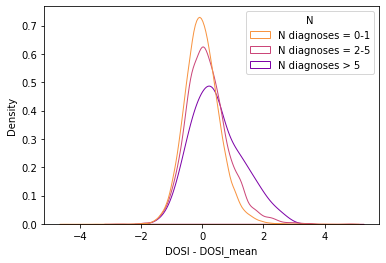

In [ ]:
data_plot['N'] = data_plot['n_diagnoses']
fig, ax = plt.subplots()
sns.kdeplot(data=data_plot, x='DOSI - DOSI_mean', hue="N", fill=True,
            common_norm=False, alpha=0, palette = 'plasma_r', ax = ax, legend = True)

plt.show()

### 2A: Excess DOSI depends on frail fraction

In [33]:
all_10 = pd.read_csv('for_plot_all_frail_10.csv', index_col=0)
all_10 = all_10[all_10['age_binned']>28]

In [34]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy import stats

In [35]:
z = np.polyfit (all_10['frail_fraction'], all_10['excess_DOSI'], 1 )
p = np.poly1d (z)

KeyError: ignored

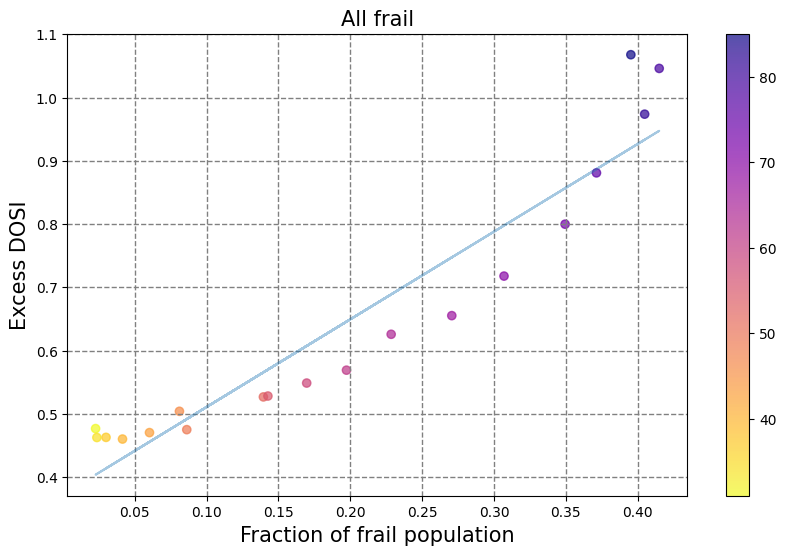

In [ ]:
fig10a = plt.figure(figsize=(10, 6))
ax10a = plt.axes()
x1 = all_10[all_10['frail_fraction']>0]
p10a = ax10a.scatter(x1['frail_fraction'], x1['excess_DOSI'], c = x1['age_binned'], alpha=0.7, cmap = cm.plasma_r )
plt.plot(x1['frail_fraction'], p(x1['frail_fraction']), alpha=0.4)

plt.ylabel('Excess DOSI', size = 15)
plt.xlim()
plt.xlabel('Fraction of frail population', size = 15)
plt.title("All frail", size=15)
plt.grid(color='grey', linestyle='--', linewidth=1)

fig10a.colorbar(p10a, ax = ax10a)

plt.show()

In [ ]:
stats.pearsonr(x1['excess_DOSI'], p(x1['frail_fraction'])) #DOSI vs trendline

PearsonRResult(statistic=0.9471339911982491, pvalue=8.094641292699463e-10)

In [ ]:
stats.pearsonr(x1['excess_DOSI'], x1['frail_fraction']) #DOSI vs frail fraction

PearsonRResult(statistic=0.9471339911982491, pvalue=8.094641292699463e-10)

### 2B: Frail fraction depends on age

In [ ]:
all_2b = all_10[all_10['age_binned']>40]
all_2b = all_2b.sort_values('age_binned')

In [ ]:
z1 = np.polyfit (all_2b['age_binned'], all_2b['frail_fraction'], 1 )
p1 = np.poly1d (z1)

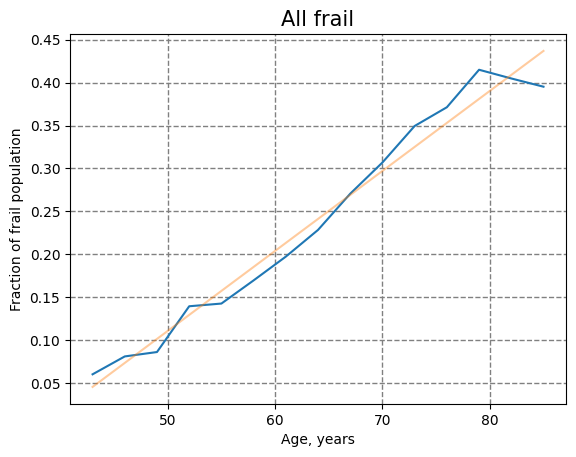

In [ ]:
plt.plot(all_2b['age_binned'], all_2b['frail_fraction'])
plt.plot(all_2b['age_binned'], p1(all_2b['age_binned']), alpha=0.4)
plt.title('All frail', size = 15)
plt.xlabel('Age, years')
plt.ylabel('Fraction of frail population')
plt.grid(color='grey', linestyle='--', linewidth=1)

In [ ]:
stats.pearsonr(all_2b['frail_fraction'], p1(all_2b['age_binned'])) #Frail fraction vs trendline

PearsonRResult(statistic=0.9878323142666585, pvalue=6.83198091215499e-12)

In [ ]:
stats.pearsonr(all_2b['frail_fraction'], all_2b['age_binned']) #Frail fraction vs Age

PearsonRResult(statistic=0.9878323142666585, pvalue=6.83198091215499e-12)

### 2С: DOSI level depends on smoking habits

In [ ]:
smoke = pd.read_csv("smoke.csv", sep='\t', index_col=0)

In [ ]:
smoke_non = smoke[smoke["Frail"]=='NonF']
smoke_frail = smoke[smoke["Frail"]!='NonF']

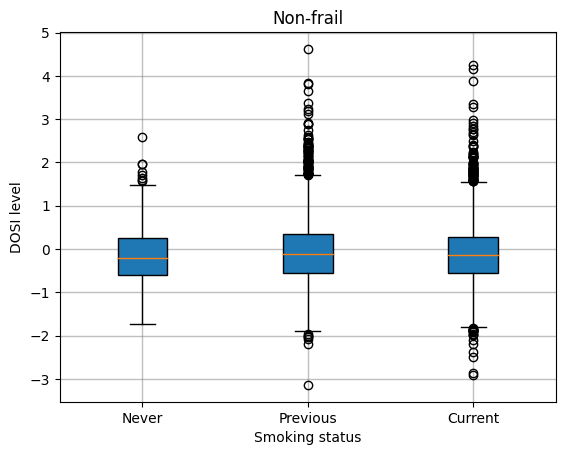

In [ ]:
value1 = smoke_non[smoke_non['status']=='Never']["log-hazards"]
value2 = smoke_non[smoke_non['status']=='Previous']["log-hazards"]
value3 = smoke_non[smoke_non['status']=='Current']["log-hazards"]

box_plot_data=[value1,value2,value3]
plt.title("Non-frail")
plt.boxplot(box_plot_data,patch_artist=True,labels=['Never','Previous','Current'])
plt.xlabel("Smoking status")
plt.ylabel("DOSI level")
plt.grid(color='grey', linewidth=1, alpha=0.5)
plt.show()

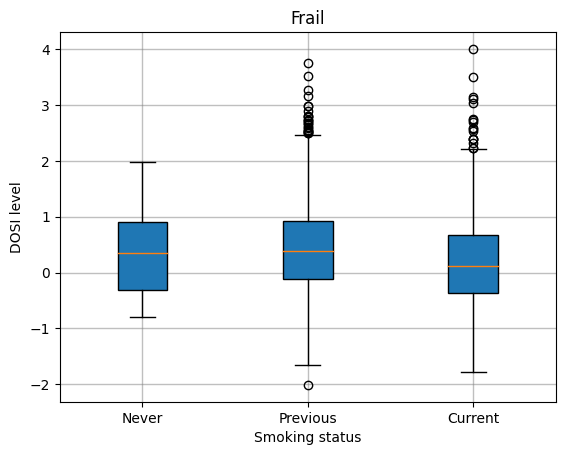

In [ ]:
value1 = smoke_frail[smoke_frail['status']=='Never']["log-hazards"]
value2 = smoke_frail[smoke_frail['status']=='Previous']["log-hazards"]
value3 = smoke_frail[smoke_frail['status']=='Current']["log-hazards"]

box_plot_data=[value1,value2,value3]
plt.title("Frail")
plt.boxplot(box_plot_data,patch_artist=True,labels=['Never','Previous','Current'])
plt.xlabel("Smoking status")
plt.ylabel("DOSI level")
plt.grid(color='grey', linewidth=1, alpha=0.5)
plt.show()

### 3D: Distribution of the inverse variance of DOSI and activity 

#### Add steps data 

In [ ]:
data_steps = pd.read_sas(".../paxraw_d.xpt")

Missing values were coded with number 62

In [ ]:
data_steps = data_steps.replace(62,0)

In [ ]:
data_steps

,SEQN,PAXSTAT,PAXCAL,PAXDAY,PAXN,PAXHOUR,PAXMINUT,PAXINTEN,PAXSTEP
0,31128.0,1.0,1.0,1.0,1.0,5.397605e-79,5.397605e-79,1.660000e+02,4.000000e+00
1,31128.0,1.0,1.0,1.0,2.0,5.397605e-79,1.000000e+00,2.700000e+01,5.397605e-79
2,31128.0,1.0,1.0,1.0,3.0,5.397605e-79,2.000000e+00,5.397605e-79,5.397605e-79
3,31128.0,1.0,1.0,1.0,4.0,5.397605e-79,3.000000e+00,2.760000e+02,4.000000e+00
4,31128.0,1.0,1.0,1.0,5.0,5.397605e-79,4.000000e+00,5.397605e-79,5.397605e-79
...,...,...,...,...,...,...,...,...,...
5373897,31854.0,1.0,1.0,3.0,6934.0,1.900000e+01,3.300000e+01,4.910000e+02,4.000000e+00
5373898,31854.0,1.0,1.0,3.0,6935.0,1.900000e+01,3.400000e+01,4.780000e+02,5.000000e+00
5373899,31854.0,1.0,1.0,3.0,6936.0,1.900000e+01,3.500000e+01,4.160000e+02,5.000000e+00
5373900,31854.0,1.0,1.0,3.0,6937.0,1.900000e+01,3.600000e+01,3.190000e+02,4.000000e+00


In [ ]:
data_steps = pd.DataFrame(data_steps.groupby(['SEQN'])['PAXSTEP'].sum(), index=None)
data_steps

,PAXSTEP
SEQN,
31128.0,84304.0
31129.0,44998.0
31131.0,67947.0
31132.0,85181.0
31133.0,36550.0
...,...
31847.0,26114.0
31848.0,8298.0
31849.0,71079.0


In [ ]:
data_steps['SEQN'] = data_steps.index
data_steps = data_steps.reset_index(drop=True)

In [ ]:
data_steps

,PAXSTEP,SEQN
0,84304.0,31128.0
1,44998.0,31129.0
2,67947.0,31131.0
3,85181.0,31132.0
4,36550.0,31133.0
...,...,...
530,26114.0,31847.0
531,8298.0,31848.0
532,71079.0,31849.0
533,72908.0,31850.0


In [ ]:
ids = Cox_all_data_fr["SEQN"]
ids_frial = data_steps["SEQN"]
data_steps_2 = data_steps[ids_frial.isin(ids)].sort_values(by=["SEQN"])
data_steps_2.shape

(495, 2)

In [ ]:
data_steps_2

,PAXSTEP,SEQN
0,84304.0,31128.0
1,44998.0,31129.0
2,67947.0,31131.0
3,85181.0,31132.0
4,36550.0,31133.0
...,...,...
530,26114.0,31847.0
531,8298.0,31848.0
532,71079.0,31849.0
533,72908.0,31850.0


#### Add age column, number of diagnosis

In [ ]:
data_steps_2['age'] = [int(Cox_all_data_fr.loc[Cox_all_data_fr['SEQN'] == i,'age_binned']) for i in data_steps_2['SEQN']]

In [ ]:
data_steps_2['n_diagnoses'] = [int(Cox_all_data_fr.loc[Cox_all_data_fr['SEQN'] == i,'n_diagnoses']) for i in data_steps_2['SEQN']]

#### Log-transformation, removement of most frial

In [ ]:
data_steps_2['ln'] = np.log(data_steps_2['PAXSTEP'])

In [ ]:
data_steps_2 = data_steps_2[data_steps_2['n_diagnoses'] < 6]

#### Plotting steps

In [ ]:
data_plot = pd.DataFrame(data_steps_2.groupby(['age'])['ln'].var())

In [ ]:
data_plot['1/var'] = 1/data_plot['ln']

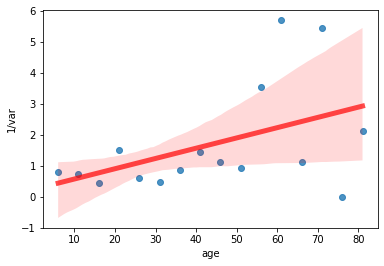

In [ ]:
sns.regplot(x=data_plot.index, y=data_plot["1/var"], line_kws={"color":"r","alpha":0.7,"lw":5})
plt.show()

Unfortunarly, the result differs from the result at paper.

#### Plotting DOSI

In [ ]:
Cox_all_data_fr_2 = Cox_all_data_fr[Cox_all_data_fr['n_diagnoses'] < 6]
Cox_all_data_fr_2 = Cox_all_data_fr_2[Cox_all_data_fr_2['age_binned'] >= 40]

In [ ]:
data_plot_dosi = pd.DataFrame(Cox_all_data_fr_2.groupby(['age_binned'])['log-hazards'].var())

In [ ]:
data_plot_dosi['1/var'] = 1/data_plot_dosi['log-hazards']

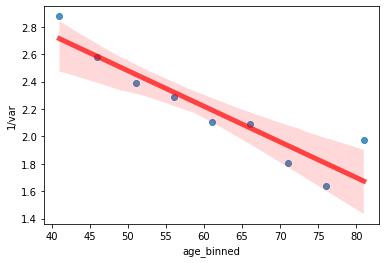

In [ ]:
sns.regplot(x=data_plot_dosi.index, y=data_plot_dosi["1/var"], line_kws={"color":"r","alpha":0.7,"lw":5})
plt.show()

#### Lifespan prediction

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
model = LinearRegression().fit(np.array(data_plot_dosi.index).reshape(-1, 1), data_plot_dosi['1/var'])

Point of Age axis intersection:

In [ ]:
float(-model.intercept_/model.coef_)

145.39184263980115